<a href="https://colab.research.google.com/github/HasibAlMuzdadid/Cat-vs-Dog-Classification/blob/main/cat_vs_dog_classification_%5Btransfer_learning_with_augmentation%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Cats vs Dogs Classification [Transfer Learning with Augmentation]**

We will need to prepare pretrained model and configure the layers that we need. We will use the convolution layers of the [InceptionV3](https://arxiv.org/abs/1512.00567) architecture as base model. 


So for preparing the input to the model, we want to fetch the pretrained weights of the `InceptionV3` model and remove the fully connected layer at the end because we will be replacing it later. Also we will augment training data here.

In [2]:
import os
import random
import zipfile
import shutil
from shutil import copyfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [5]:
# Download the dataset
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2022-06-30 19:56:19--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.54.48.114, 2600:1409:3000:4a4::e59, 2600:1409:3000:48e::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.54.48.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   133MB/s    in 6.3s    

2022-06-30 19:56:26 (125 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [6]:
source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')


# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12501 images of dogs.
There are 12501 images of cats.


In [7]:
# Define root directory
root_dir = '/tmp/cats-v-dogs'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)


def create_train_val_dirs(root_path):
  
  os.makedirs(os.path.join(root_dir,"training"))
  os.makedirs(os.path.join(f"{root_dir}/training", "dogs"))
  os.makedirs(os.path.join(f"{root_dir}/training", "cats"))
  os.makedirs(os.path.join(root_dir,"validation"))
  os.makedirs(os.path.join(f"{root_dir}/validation", "dogs"))
  os.makedirs(os.path.join(f"{root_dir}/validation", "cats"))

  
try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [8]:
# Testing create_train_val_dirs() function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training/dogs
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/validation/dogs
/tmp/cats-v-dogs/validation/cats


In [9]:
#  Spliting the whole data into train and test set
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

  processed_data = []
  
  for filename in os.listdir(SOURCE_DIR) :
    file = SOURCE_DIR + filename
    if os.path.getsize(file) > 0 :
      processed_data.append(filename)
    else :
      print(f"{filename} is zero length, so ignoring.")

  randomized_data = random.sample(processed_data, len(processed_data))

  training_length = int(len(randomized_data)*SPLIT_SIZE)
  validation_length = int(len(randomized_data) - training_length)

  training_data = randomized_data[:training_length]
  validation_data = randomized_data[-validation_length:]


  for filename in training_data :
    present_file = SOURCE_DIR + filename
    destination = TRAINING_DIR + filename
    copyfile(present_file, destination)


  for filename in validation_data :
    present_file = SOURCE_DIR + filename
    destination = VALIDATION_DIR + filename
    copyfile(present_file, destination)


In [10]:
# Defining paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Empty directories in case running this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

# proportion of images used for training
split_size = .9

# Messages about zero length images will be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [11]:
# number of images for each class and set
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")

There are 11250 images of cats for training
There are 11250 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation


Sample Cat Image:


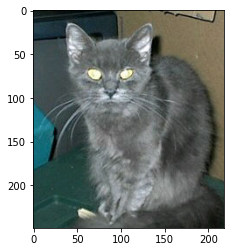


Sample Dog Image:


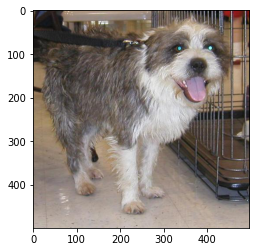

In [12]:
print("Sample Cat Image:")
plt.imshow(load_img(f"{os.path.join(TRAINING_CATS_DIR, os.listdir(TRAINING_CATS_DIR)[0])}"))
plt.show()

print("\nSample Dog Image:")
plt.imshow(load_img(f"{os.path.join(TRAINING_DOGS_DIR, os.listdir(TRAINING_DOGS_DIR)[0])}"))
plt.show()

In [13]:
# Load the first example of a cat
sample_image  = load_img(f"{os.path.join(TRAINING_CATS_DIR, os.listdir(TRAINING_CATS_DIR)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"This image has shape: {sample_array.shape}")

This image has shape: (249, 218, 3)


In [14]:
# Load the first example of a dog
sample_image  = load_img(f"{os.path.join(TRAINING_DOGS_DIR, os.listdir(TRAINING_DOGS_DIR)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"This image has shape: {sample_array.shape}")

This image has shape: (500, 497, 3)


All the images are not in same shape.

In [15]:
#  Creating the training and validation data generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Instantiating the ImageDataGenerator class also normalization and augmentation
  train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                     rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=100,
                                                      class_mode="binary",
                                                      target_size=(150, 150))

  
  validation_datagen = ImageDataGenerator(rescale=1.0/255)
  
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=100,
                                                                class_mode="binary",
                                                                target_size=(150, 150))


  return train_generator, validation_generator

In [16]:
# Testing the generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [17]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-06-30 19:57:35--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.128, 173.194.203.128, 74.125.199.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   246MB/s    in 0.3s    

2022-06-30 19:57:35 (246 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [18]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

We will use up to `mixed_7` as our base model and add to that. This is because the original last layer might be too specialized in what it has learned so it might not translate well into our application. `mixed_7` on the other hand will be more generalized and we can start with that for our application. 

In [19]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [20]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


In [21]:
# Choosing `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [22]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


Adding dense layers to our model. These will be the layers that we will train and is tasked with recognizing cats and dogs. We will add a [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer as well to regularize the output and avoid overfitting.

In [23]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(inputs = pre_trained_model.input, outputs = x) 

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [24]:
# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


In [25]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [26]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so canceling training!")
      self.model.stop_training = True

In [27]:
callbacks = myCallback()

# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 20,
            verbose = 1,
            callbacks=[callbacks])

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 0.5613 - accuracy: 0.8942

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

225/225 [==============================] - 189s 771ms/step - loss: 0.5613 - accuracy: 0.8942 - val_loss: 0.1079 - val_accuracy: 0.9620
Epoch 2/20
225/225 [==============================] - 172s 763ms/step - loss: 0.1776 - accuracy: 0.9276 - val_loss: 0.1311 - val_accuracy: 0.9512
Epoch 3/20
225/225 [==============================] - 171s 760ms/step - loss: 0.1570 - accuracy: 0.9370 - val_loss: 0.1137 - val_accuracy: 0.9648
Epoch 4/20
225/225 [==============================] - 171s 758ms/step - loss: 0.1553 - accuracy: 0.9390 - val_loss: 0.1006 - val_accuracy: 0.9640
Epoch 5/20
225/225 [==============================] - 171s 758ms/step - loss: 0.1449 - accuracy: 0.9422 - val_loss: 0.0937 - val_accuracy: 0.9676
Epoch 6/20
225/225 [==============================] - 170s 757ms/step - loss: 0.1417 - accuracy: 0.9437 - val_loss: 0.0861 - val_accuracy: 0.9700
Epoch 7/20
225/225 [==============================] - 171s 759ms/step - loss: 0.1321 - accuracy: 0.9486 - val_loss: 0.1492 - val_accura

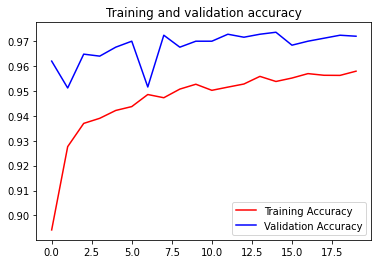

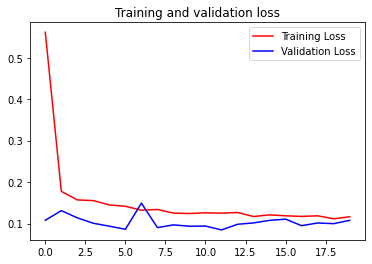

In [28]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # number of epochs

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', label= "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label= "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
print("")


# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', label= "Training Loss")
plt.plot(epochs, val_loss, 'b', label= "Validation Loss")
plt.title('Training and validation loss')
plt.legend()
plt.show()